# Crime Patterns in Toronto (K-Prototypes and K-means Clustering)

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [16]:
pd.options.mode.chained_assignment = None 

## Data Preparation and Cleaning

In [1530]:
# Read in datasets for each crime category
assault = pd.read_csv("Assault_2014_to_2019.csv")
autotheft = pd.read_csv("Auto_Theft_2014_to_2019.csv")
breakandenter = pd.read_csv("Break_and_Enter_2014_to_2019.csv")
robbery = pd.read_csv("Robbery_2014_to_2019.csv")
theftover = pd.read_csv("Theft_Over_2014_to_2019.csv")
homicide = pd.read_csv("Homicide.csv")

assault.head(3)

,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,...,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Long,Lat,ObjectId
0,1125,GO-20142334367,1403307000000,1403307480000,Commercial,1410,100,Aggravated Assault,2014,June,...,171.0,Friday,23,Assault,D12,110,Keelesdale-Eglinton West (110),-79.467857,43.681961,1
1,1126,GO-20142334465,1403307000000,1403307600000,Apartment,1430,100,Assault,2014,June,...,171.0,Friday,23,Assault,D32,35,Westminster-Branson (35),-79.450943,43.772316,2
2,1127,GO-20142418354,1404344400000,1404344400000,House,1430,100,Assault,2014,July,...,183.0,Wednesday,23,Assault,D43,137,Woburn (137),-79.222183,43.763889,3


In [1532]:
# Rename columns in 'homicide' for compatibility with other datasets
homicide = homicide.rename(columns={'Event_Unique_ID': 'event_unique_id', 
                                    'Occurrence_year': 'occurrenceyear',
                                    'Homicide_Type': 'offence',
                                    'Occurrence_Date': 'occurrencedate',})

In [1509]:
# Concat datasets into single dataframe with keys for cross-sectional referencing 
crime_label = ['Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over', 'Homicide']
df = pd.concat([assault, autotheft, breakandenter, robbery, theftover, homicide], keys=crime_label, sort=False)

# Keep only relevent columns
df = df[['event_unique_id', 'occurrencedate', 'offence', 'occurrenceyear', 'occurrencemonth', 
        'occurrenceday', 'occurrencedayofweek', 'occurrencehour', 'MCI', 'Neighbourhood']]

# Drop all records that are pre-2014 
df = df[(df['occurrenceyear']>2013)]

In [1510]:
# Covert milliseconds since 1,1,1970 to days since 1,1,1970
df['occurrencedate'] = df['occurrencedate'].apply(lambda x : (x/(24*60*60*1000)))

In [1511]:
# Create function to convert serial format to '%Y-%m-%d' format
import datetime
def serial_to_date(serial):
    date = datetime.datetime(1970,1,1,0,0) + datetime.timedelta(serial)
    return date.strftime('%Y-%m-%d')

# Create new 'Date/Time' with converted dates from function
df['Date/Time'] = pd.to_datetime(df['occurrencedate'].apply(lambda x: serial_to_date(x)))

# Drop occurrencedate column 
df = df.drop(['occurrencedate'],axis=1)

In [1512]:
df.xs('Homicide').head()

,event_unique_id,offence,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofweek,occurrencehour,MCI,Neighbourhood,Date/Time
101,GO-2016851941,Other,2016.0,NaN,NaN,NaN,NaN,NaN,Church-Yonge Corridor (75),2016-05-18
102,GO-2016656231,Other,2016.0,NaN,NaN,NaN,NaN,NaN,Weston (113),2016-04-17
103,GO-2016965196,Shooting,2016.0,NaN,NaN,NaN,NaN,NaN,Humbermede (22),2016-06-03
104,GO-2016989870,Shooting,2016.0,NaN,NaN,NaN,NaN,NaN,Mount Pleasant West (104),2016-06-07
105,GO-20161148938,Shooting,2016.0,NaN,NaN,NaN,NaN,NaN,Kensington-Chinatown (78),2016-07-01


In [1513]:
# Impute NaN values for homicide records 

# Impute Months for 'occurrencemonth'
monthmap = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
homicide_month = df.xs('Homicide')['Date/Time'].dt.month.map(monthmap)
df.xs('Homicide')['occurrencemonth'] = homicide_month

# Impute week days for 'occurrencedayofweek'
weekmap = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
homicide_dayofweek = df.xs('Homicide')['Date/Time'].dt.dayofweek.map(weekmap)
df.xs('Homicide')['occurrencedayofweek'] = homicide_dayofweek

# Impute day of the month for 'occurrenceday'
df.xs('Homicide')['occurrenceday'] = df.xs('Homicide')['Date/Time'].dt.day.astype('float64')

# Impute hours of the day for 'occurrencehour'.
df.xs('Homicide')['occurrencehour'] = 0.0

In [1514]:
# Impute missing values for 'MCI' column for homicide records
df.xs('Homicide')['MCI'] = 'Homicide'

# Replce 'Other' to 'Homicide - Other' to avoid confusion
df.xs('Homicide')['offence'].replace({'Other':'Homicide - Other', 'r':'responsive'}, inplace=True)

In [1515]:
df.xs('Homicide').head(3)

,event_unique_id,offence,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofweek,occurrencehour,MCI,Neighbourhood,Date/Time
101,GO-2016851941,Homicide - Other,2016.0,May,18.0,Wednesday,0.0,Homicide,Church-Yonge Corridor (75),2016-05-18
102,GO-2016656231,Homicide - Other,2016.0,April,17.0,Sunday,0.0,Homicide,Weston (113),2016-04-17
103,GO-2016965196,Shooting,2016.0,June,3.0,Friday,0.0,Homicide,Humbermede (22),2016-06-03


In [1516]:
# Remove white space after string
df['occurrencedayofweek'] = df['occurrencedayofweek'].str.rstrip()

# Convert float64 date columns to int64 
df[['occurrenceyear','occurrenceday','occurrencehour']] = df[['occurrenceyear','occurrenceday','occurrencehour']].astype(np.int64)

In [1517]:
import re
# Remove bracketed CDN numbers in 'Neighbourhood' column
df['Neighbourhood'] = df['Neighbourhood'].apply(lambda x: re.sub(" [\(\[].*?[\)\]]", "", x))

In [1518]:
df.head(3)

event_unique_id             offence  occurrenceyear occurrencemonth  \
Assault 0  GO-20142334367  Aggravated Assault            2014            June   
        1  GO-20142334465             Assault            2014            June   
        2  GO-20142418354             Assault            2014            July   

           occurrenceday occurrencedayofweek  occurrencehour      MCI  \
Assault 0             20              Friday              23  Assault   
        1             20              Friday              23  Assault   
        2              2           Wednesday              23  Assault   

                      Neighbourhood  Date/Time  
Assault 0  Keelesdale-Eglinton West 2014-06-20  
        1       Westminster-Branson 2014-06-20  
        2                    Woburn 2014-07-02

In [1519]:
# Read in temperature data. Covert 'Date/Time' column to datetime format. 
temp = pd.read_csv('torontotemp_2014_to_2019.csv')
temp['Date/Time'] = pd.to_datetime(temp['Date/Time'])

In [1520]:
# Merge df with temp
df = pd.merge(df, temp, how='left', on='Date/Time')
df.head()

,event_unique_id,offence,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofweek,occurrencehour,MCI,Neighbourhood,Date/Time,mean_temp,total_rain,total_snow,total_precip,snow_on_ground
0,GO-20142334367,Aggravated Assault,2014,June,20,Friday,23,Assault,Keelesdale-Eglinton West,2014-06-20,17.0,0.0,0.0,0.0,0
1,GO-20142334465,Assault,2014,June,20,Friday,23,Assault,Westminster-Branson,2014-06-20,17.0,0.0,0.0,0.0,0
2,GO-20142418354,Assault,2014,July,2,Wednesday,23,Assault,Woburn,2014-07-02,24.3,1.4,0.0,1.4,0
3,GO-20142418354,Assault,2014,July,2,Wednesday,23,Assault,Woburn,2014-07-02,24.3,1.4,0.0,1.4,0
4,GO-20142418354,Assault,2014,July,2,Wednesday,23,Assault,Woburn,2014-07-02,24.3,1.4,0.0,1.4,0


## Data Exploration

**Count by Year for each Crime Category**

The table below shows the number of occurrences for each category of crime from 2014 to 2019. The number of assaults, auto thefts, break and enters, and thefts appear to be increasing year after year. There was a peak in robberies in 2017, and the number of cases seem to be dropping every year since. In 2018, there was a huge spike in homicides in Toronto. Although that number has reduced in 2019, the number of cases still remains high compared to prior years.

In [108]:
# Generate pivot table w/ type of crime for rows, years for columns, and count of crimes as values. 
crime_piv = pd.pivot_table(df, values='event_unique_id', index='MCI', columns='occurrenceyear', aggfunc='count')

# Create crime totals
crime_total = df.groupby(['MCI'])['event_unique_id'].count()
crime_total = pd.DataFrame(crime_total).rename(columns={'event_unique_id':'Crime Total'})

# Create yearly totals
year_total = df.groupby(['occurrenceyear'])['event_unique_id'].count()
year_total = pd.DataFrame(year_total).rename(columns={'event_unique_id':'Year Total'}).transpose()
year_total['Crime Total'] = year_total.iloc[0].sum()
year_total.columns.name=''

# Merge totals to pivot table
crime_piv = crime_piv.join(crime_total, how='outer')
crime_piv = pd.concat([crime_piv, year_total]).sort_index(level=0)
crime_piv

,2014,2015,2016,2017,2018,2019,Crime Total
Assault,16395,17738,18538,19086,19252,19600,110609
Auto Theft,3485,3195,3258,3545,4710,5137,23330
Break and Enter,7178,6899,6387,6877,7595,8278,43214
Homicide,58,59,75,65,96,78,431
Robbery,3586,3464,3613,3898,3531,3408,21500
Theft Over,994,1020,1013,1155,1235,1251,6668
Year Total,31696,32375,32884,34626,36419,37752,205752


<b> Types of Offences </b>

The data provides information on over fifty types of offences between the six crime categories. The top 40 offences are graphed out below in a barplot with bars coloured coded to reflect the category of crime they fall under.

*The offences 'Assault' and 'B&E' under the categories Assault and B&E respectively are excluded for being vaque and offering little information.*

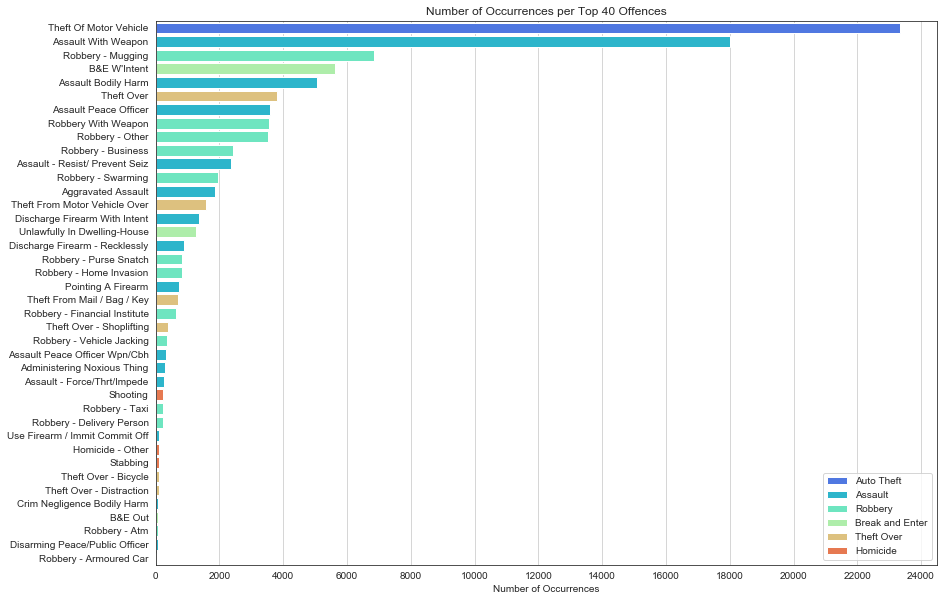

In [887]:
# Sum the number of occurences for each offence and left join 'MCI' column. 
offences = pd.DataFrame(df.groupby('offence').count()['event_unique_id'].sort_values(ascending=False)).reset_index()
offences = offences.merge(df[['offence', 'MCI']].drop_duplicates(subset=['offence']), how='left', on='offence')

# Remove 'Assault' and 'B&E'.
offences = offences[(offences['offence'] != 'Assault') & (offences['offence'] != 'B&E')]

# Plot horizontal barplot 
plt.figure(figsize=(14,10))
sns.barplot(x='event_unique_id', y='offence', hue='MCI', palette='rainbow', data=offences[:40], dodge=False)
plt.title('Number of Occurrences per Top 40 Offences')
plt.ylabel(None)
plt.xlabel('Number of Occurrences')
plt.grid(axis='x')
plt.xticks(range(0,25000,2000))
plt.legend(loc='lower right');

<b> Top 5 Neighbourhoods for Crime</b>

The chart below ranks the top five neighbourhoods in Toronto where each crime category occurs the most. Some notable areas that come up across different lists include the Church-Yonge Corridor, Waterfront Communities, and Moss Park.

In [446]:
# The top 5 dangerous neighbourhoods by type of crime 
hood_desc = pd.DataFrame()
for each in df['MCI'].unique():
    hood_desc[each] = df[(df['MCI']==each)]['Neighbourhood'].value_counts().head(5).index.tolist()

hood_desc.index += 1
hood_desc.index.name='Rank'
hood_desc

,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,Homicide
Rank,,,,,,
1,Waterfront Communities-The Island,West Humber-Clairville,Waterfront Communities-The Island,Church-Yonge Corridor,Waterfront Communities-The Island,Moss Park
2,Bay Street Corridor,Islington-City Centre West,Church-Yonge Corridor,Moss Park,West Humber-Clairville,Mount Olive-Silverstone-Jamestown
3,Church-Yonge Corridor,Downsview-Roding-CFB,Bay Street Corridor,Bay Street Corridor,Bay Street Corridor,Church-Yonge Corridor
4,Moss Park,York University Heights,Kensington-Chinatown,West Humber-Clairville,Islington-City Centre West,South Riverdale
5,West Hill,Humber Summit,Moss Park,Woburn,York University Heights,Malvern


With data presented in the above format, it is easy to now iterate through each crime category and plot the number of occurrences in their respective top five neighbourhoods. Although the code below uses the 'occurrencehour' column, it makes sense to plot against year, month, or days in a month as well. 

From the plots above, it becomes clear that different crimes show different activity throughout the day. For instance autho thefts and break & enters appear to occur at anytime of the day, while robberies and assaults have peak hours and downtimes.

*Note: Homicide is excluded below since all records have 'occurrencehour' arbitrarily set to 0 as per the TPS.*

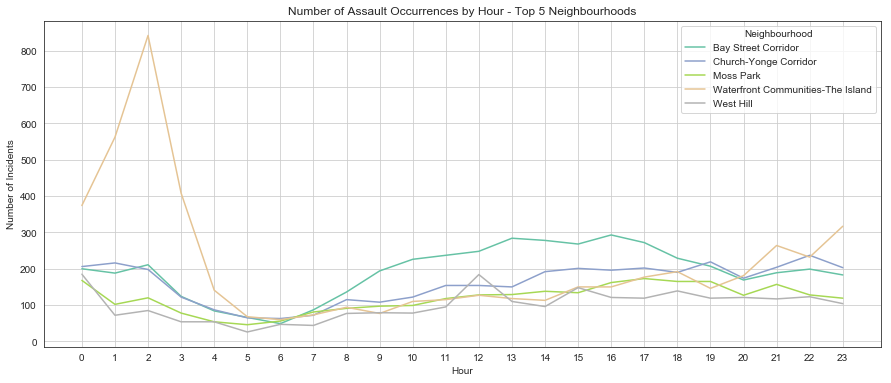

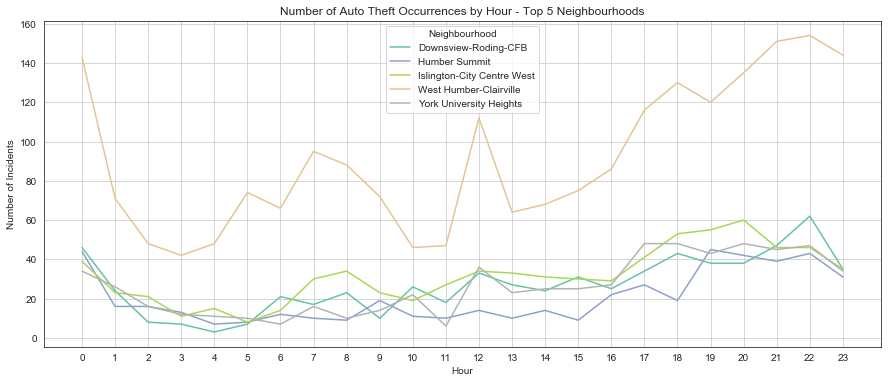

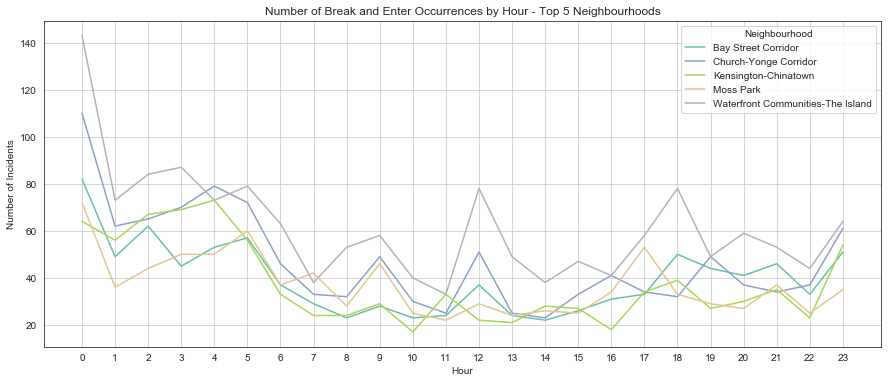

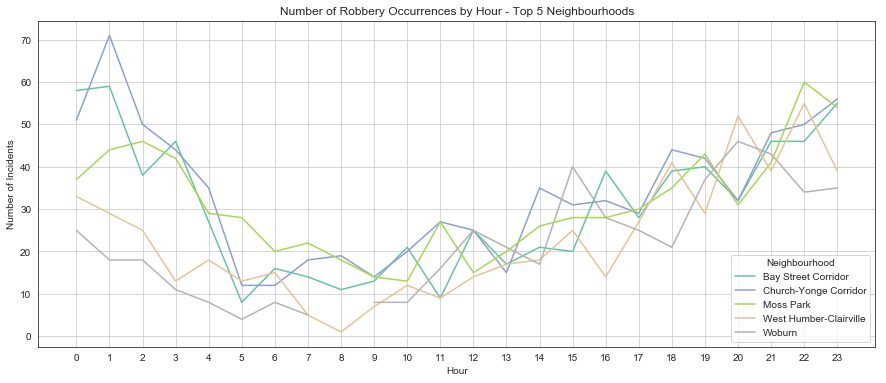

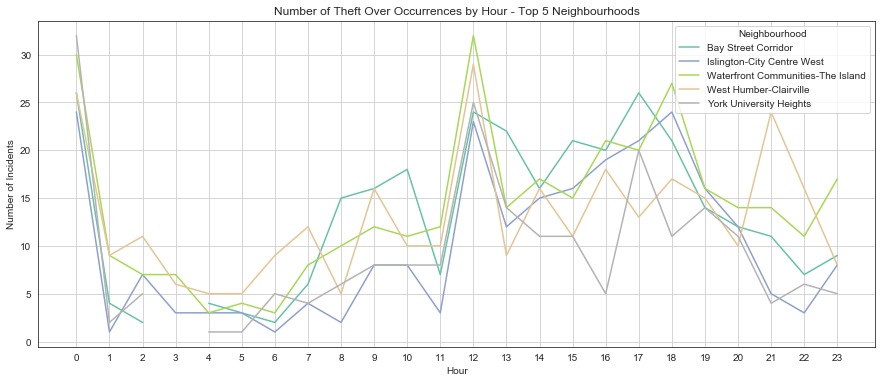

In [1047]:
# Iterate through each crime and plot # of occurrences against 'occurrencehour' in their respective top 5 neighbourhoods.
for each in hood_desc.columns[:-1]:
    df[(df['MCI']==each)].loc[df['Neighbourhood'].isin(hood_desc[each])].groupby(
        by=['occurrencehour','Neighbourhood']).count()['event_unique_id'].unstack(level=1).plot(
        figsize=(15,6), cmap='Set2')                                                                                       
    plt.title('Number of %s Occurrences by Hour - Top 5 Neighbourhoods' %(each))
    plt.ylabel("Number of Incidents")
    plt.xlabel("Hour")
    plt.xticks(range(0,24))
    plt.grid()

For curiosity, the below chart lists the top 5 *safest* Toronto neighbourhoods for each category of crime.

In [326]:
# The top 5 safest neighbourhoods by type of crime 
hood_asc = pd.DataFrame()
for each in df['MCI'].unique():
    hood_asc[each] = df[(df['MCI']==each)]['Neighbourhood'].value_counts(ascending=True).head(5).index.tolist()
hood_asc.index += 1
hood_asc.index.name='Rank'
hood_asc

,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,Homicide
Rank,,,,,,
1,Forest Hill South,Guildwood,Elms-Old Rexdale,Bridle Path-Sunnybrook-York Mills,Broadview North,Leaside-Bennington
2,Markland Wood,Woodbine-Lumsden,Lambton Baby Point,Bayview Woods-Steeles,Lambton Baby Point,Milliken
3,Lawrence Park South,Old East York,Maple Leaf,Lawrence Park North,Runnymede-Bloor West Village,Clanton Park
4,Princess-Rosethorn,Yonge-St.Clair,Caledonia-Fairbank,Woodbine-Lumsden,Rexdale-Kipling,Rosedale-Moore Park
5,Kingsway South,Broadview North,Guildwood,Maple Leaf,Elms-Old Rexdale,Dufferin Grove


**Occurrences by Day of Week and Hour of Day**

Overall it is evident that crime increases gradually throughout the day. Crime is most frequent on Saturday and Sunday between midnight and 3AM. Occurrences are at their lowest in the early morning hours of 3AM to 7AM. Apparently this "low-activity" window is pushed back 2 hours on weekends. There is a sudden spike in activity right at midnight and noon, however it may account for records where the TPS arbitrarily set to 0 or 12.

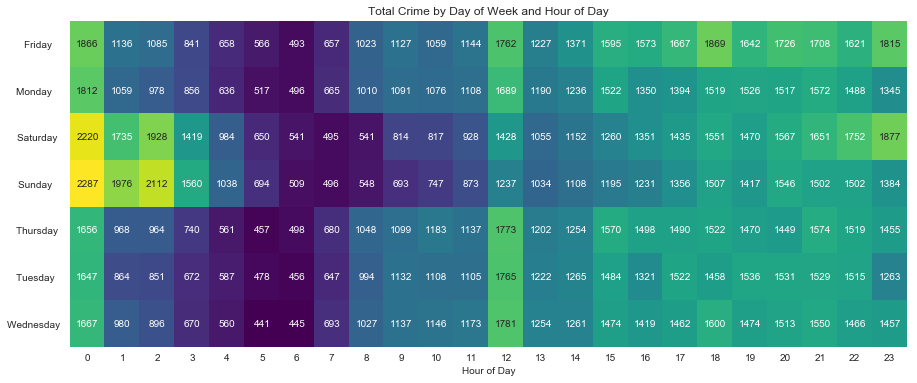

In [1005]:
bydayhour = df[(df['MCI']!='Homicide')].groupby(by=['occurrencedayofweek','occurrencehour']).count()['event_unique_id'].unstack()

plt.figure(figsize=(15,6))
sns.heatmap(bydayhour, annot=True, fmt="d", cmap='viridis', cbar=False)
plt.title("Total Crime by Day of Week and Hour of Day")
ylabel = plt.ylabel(None)
xlabel = plt.xlabel("Hour of Day")

**Correlation between Temperature and Occurrences for each Crime**

To determine the correlation between the number of occurrences and temperature, each category of crime must be expressed in the form a continuous variable. The following approach aggregates occurrences by the date so that each record represents how many times each crime occurred on any given day. By doing this, it becomes possible to plot mean temperature against each crime.

In [927]:
by_date = pd.DataFrame(index=df['Date/Time'].unique()).sort_index()

for each in df['MCI'].unique():
    by_date = pd.concat([by_date, df[(df['MCI']==each)]['Date/Time'].value_counts()], axis=1)

by_date.columns = df['MCI'].unique()
by_date.fillna(0, inplace=True)

# Round mean_temp to the nearest whole degree celcius 
by_date_temp = by_date.merge(temp[['mean_temp','Date/Time']], left_index=True, right_on='Date/Time').set_index('Date/Time')
by_date_temp['mean_temp'] = by_date_temp['mean_temp'].apply(lambda x: round(x))
by_date_temp.head(3)

,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,Homicide,mean_temp
Date/Time,,,,,,,
2014-01-01,168,3,24,3.0,16.0,0.0,-12
2014-01-02,24,5,18,4.0,2.0,0.0,-18
2014-01-03,26,9,24,2.0,4.0,1.0,-16


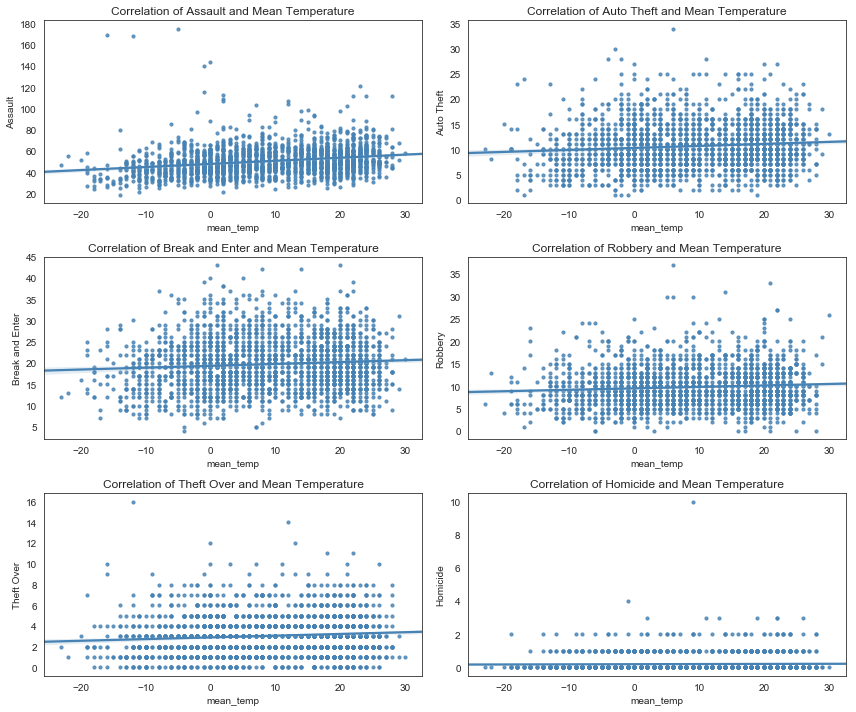

In [901]:
cols = df_temp['MCI'].unique()

# Iterate through each crime category and plot each against mean_temp
fig, ax = plt.subplots(3,2, figsize=(12, 10))
for i, axis in enumerate(ax.flatten()):        
    ax_ = sns.regplot(x='mean_temp', y=cols[i], data=by_date, scatter_kws={'s':10}, 
                      color='steelblue', ax=axis).set_title('Correlation of %s and Mean Temperature' %(cols[i]))
plt.tight_layout()

The regplots above present the correlation of each crime on the y-axis and mean temperature on the x-axis. Note the temperature values are rounded to the nearest whole degree celcius as a way to balance to limited amount of values on the y-axis for some crimes, namely Theft Over and Homicide. When aggregating occurrences by the date, there appears to be little to no correlation between the number of occurrences and the mean temperature. Assaults show a slight positive correlation.

## K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

**Preprocessing Data**

In [929]:
by_date = by_date.merge(temp, left_index=True, right_on='Date/Time').set_index('Date/Time')

scaler = StandardScaler()
by_date_scaled = scaler.fit_transform(by_date)

**Find Optimal Number of Clusters**

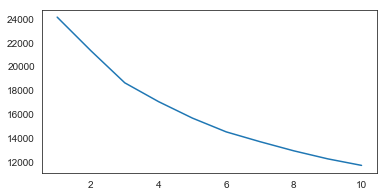

In [930]:
clusters = []
for i in range(1, 11):
    km = KMeans(n_clusters=i).fit(by_date_scaled)
    clusters.append(km.inertia_)

fig, ax = plt.subplots(figsize=(6, 3))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
plt.show()

In [931]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(crimes_per_day_scaled)
crimes_per_day['clusters'] = kmeans.labels_

**Analysis of K-means Clustering**

In [933]:
crimes_per_day.groupby('clusters').mean()

,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,Homicide,mean_temp,total_rain,total_snow,total_precip,snow_on_ground
clusters,,,,,,,,,,,
0,50.425676,11.398649,20.000000,9.601351,3.067568,0.148649,12.922973,19.879730,0.272297,20.548649,0.378378
1,51.816715,10.874352,20.214409,10.029971,3.142363,0.205764,11.171182,0.882017,0.050778,0.941960,0.344669
2,43.000000,9.012987,16.824675,8.691558,2.474026,0.168831,-7.300000,0.261364,2.028571,2.026948,15.373377


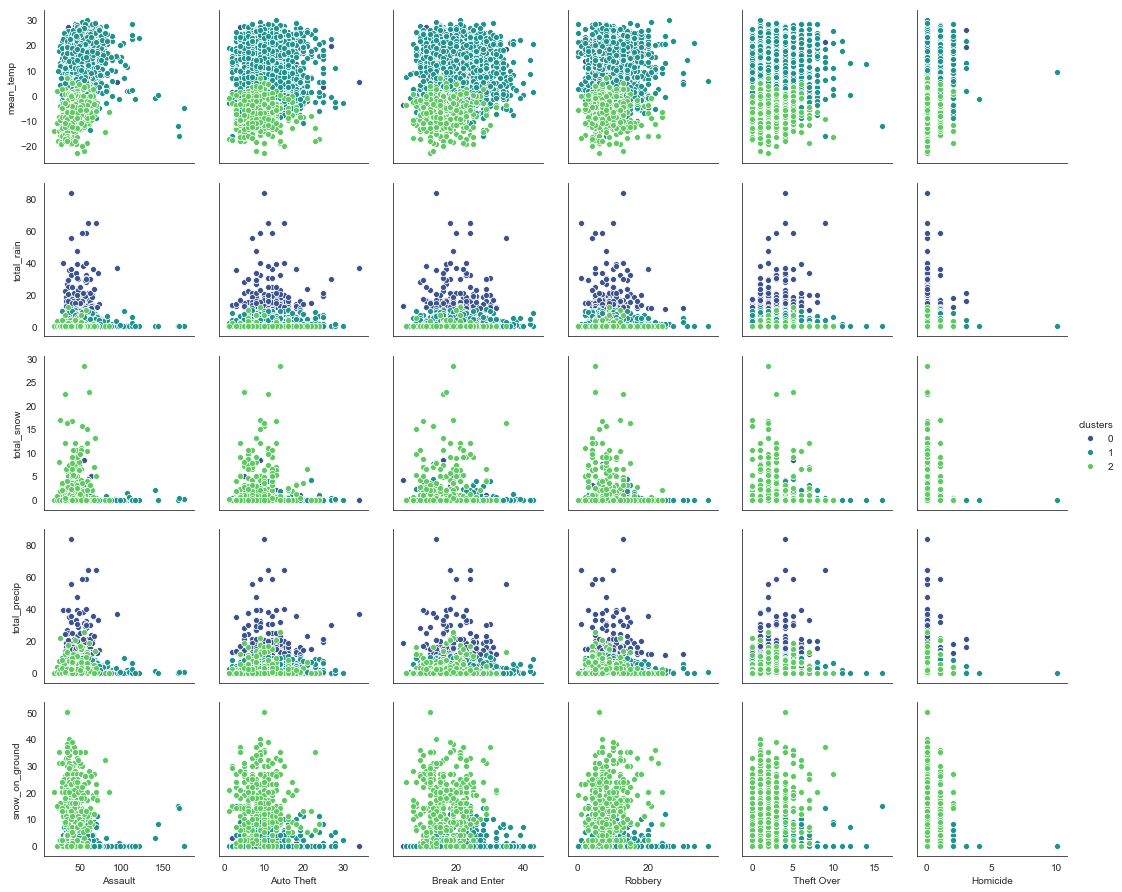

In [934]:
sns.pairplot(crimes_per_day, 
             x_vars=df['MCI'].unique(),  # Crime categories on x-axis
             y_vars=temp.columns[1:],  # Temp features on y-axis
             hue='clusters', palette='viridis');

**Visualize Clusters in 2-Dimensions using PCA**

In [935]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
crimes_per_day_pca = pca.fit_transform(crimes_per_day_scaled)

crimes_per_day_pca = pd.DataFrame(crimes_per_day_pca, columns=['PC1','PC2'])
crimes_per_day_pca['clusters'] = kmeans.labels_

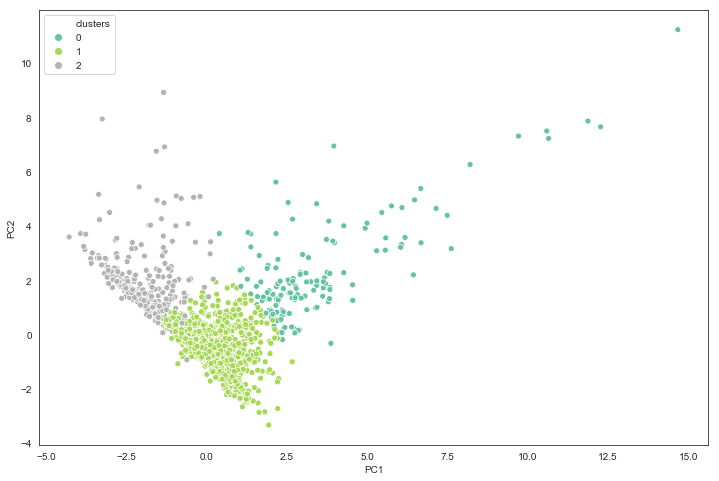

In [936]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='PC1', y='PC2', hue='clusters', data=crimes_per_day_pca, palette='Set2');

## K-Prototypes Clustering

In [ ]:
from sklearn.preprocessing import LabelEncoder
from kmodes.kprototypes import KPrototypes

**Preprocessing Data**

In [1031]:
df_cluster = df.copy()
df_cluster = df.drop(['event_unique_id','offence','Date/Time'], axis=1)

,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofweek,occurrencehour,MCI,Neighbourhood,mean_temp,total_rain,total_snow,total_precip,snow_on_ground
0,2014,June,20,Friday,23,Assault,Keelesdale-Eglinton West,17.0,0.0,0.0,0.0,0
1,2014,June,20,Friday,23,Assault,Westminster-Branson,17.0,0.0,0.0,0.0,0
2,2014,July,2,Wednesday,23,Assault,Woburn,24.3,1.4,0.0,1.4,0
3,2014,July,2,Wednesday,23,Assault,Woburn,24.3,1.4,0.0,1.4,0
4,2014,July,2,Wednesday,23,Assault,Woburn,24.3,1.4,0.0,1.4,0


In [1032]:
cols_to_scale = ['mean_temp', 'total_rain', 'total_snow', 'total_precip', 'snow_on_ground']
cols_to_label = ['occurrenceyear', 'occurrencemonth', 'occurrencedayofweek', 'MCI', 'Neighbourhood']

In [1033]:
encoder = LabelEncoder()

df_cluster[cols_to_scale] = scaler.fit_transform(df_cluster[cols_to_scale])
df_cluster[cols_to_label] = df_cluster[cols_to_label].apply(encoder.fit_transform)

df_cluster_matrix = df_cluster.values

**Find Optimal Number of Clusters**

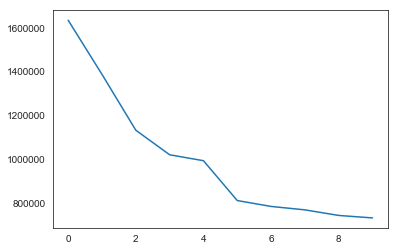

In [1116]:
cost = []
for i in list(range(1,11)):
    kp = KPrototypes(n_clusters=i, n_init=1, init='Cao')
    kp.fit_predict(df_cluster_matrix, categorical=[0,1,2,3,4,5,6])
    cost.append(kp.cost_)
    
plt.plot(cost);

In [1118]:
# Run kprotoypes clustering using 5 clusters 
kp = KPrototypes(n_clusters=5, init='Cao', n_init=1)
clusters = kp.fit_predict(df_cluster_matrix, categorical=[0,1,2,3,4,5,6])

In [1122]:
# Add clusters to original dataset
df_with_clusters = df.copy()
df_with_clusters['clusters'] = clusters.astype(np.int64)

**Analysis of K-Prototypes Clustering**

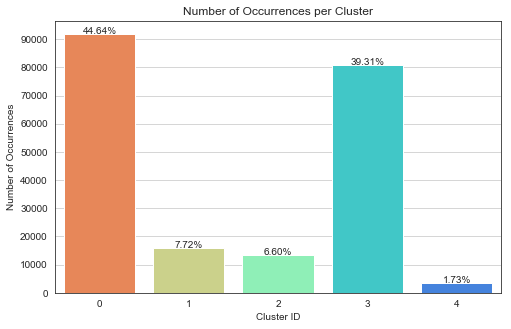

In [1237]:
cluster_count = pd.DataFrame(df_with_clusters['clusters'].value_counts())

plt.figure(figsize=(8,5))
ax = sns.barplot(x=cluster_count.index, y=cluster_count['clusters'], palette='rainbow_r')
total = float(len(df_with_clusters))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height, '{0:.2%}'.format(height/total), ha='center')

plt.title('Number of Occurrences per Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Occurrences')
plt.grid(axis='y')
plt.yticks(range(0,100000,10000));

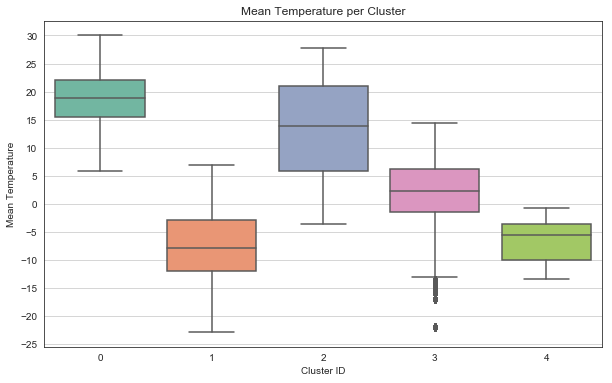

In [1384]:
plt.figure(figsize=(10,6))
box_plot = sns.boxplot(x='clusters', y='mean_temp',data=df_with_clusters, palette='Set2')
plt.title('Mean Temperature per Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Mean Temperature')
plt.grid(axis='y')
plt.yticks(range(-25,35,5));

In [1124]:
df_with_clusters.iloc[:,-6:].groupby('clusters').mean()

,mean_temp,total_rain,total_snow,total_precip,snow_on_ground
clusters,,,,,
0,18.630287,0.955671,0.001520,0.958650,0.000000
1,-7.477071,0.339562,0.413863,0.671670,20.800302
2,13.129153,20.190127,0.130494,20.467885,0.286746
3,1.885529,0.772101,0.206469,0.980807,1.056164
4,-6.569652,0.699663,10.681555,10.779281,8.504211


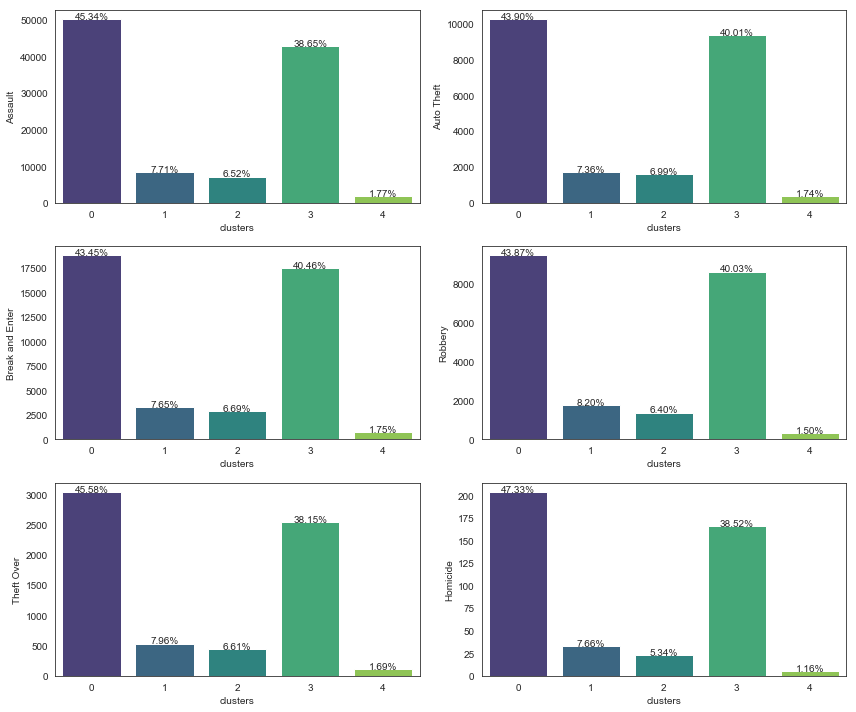

In [1459]:
# Pivot by crime category and cluster ID, and aggregate by the number of occurrences 
cluster_piv = pd.pivot_table(df_with_clusters, values='event_unique_id', 
                             index='clusters', columns='MCI', aggfunc='count').reset_index()

# Barplot for each crime category and percentages of each cluster in their respective crimes. 
fig, ax = plt.subplots(3,2, figsize=(12,10))
for i, axis in enumerate(ax.flatten()):        
    ax_ = sns.barplot(x='clusters', y=cols[i], data=cluster_piv, palette='viridis', ax=axis)
    
    total = float(len(df_with_clusters[(df_with_clusters['MCI']==cols[i])]))
    for p in ax_.patches:
        height = p.get_height()
        ax_.text(p.get_x()+p.get_width()/2., height, '{0:.2%}'.format(height/total), ha="center")
    
plt.tight_layout()

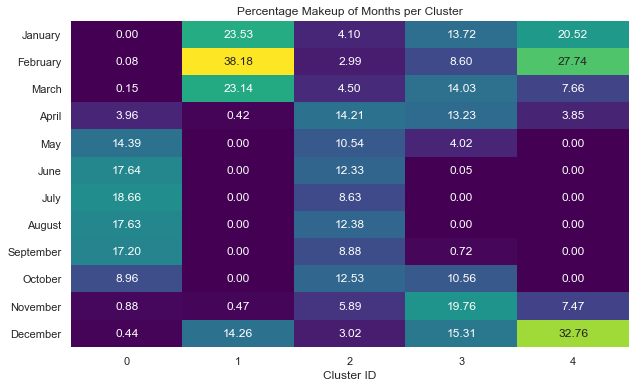

In [1528]:
cluster_piv = pd.pivot_table(df_with_clusters, values='event_unique_id', columns='clusters', 
                             index='occurrencemonth', aggfunc='count')
cluster_piv = cluster_piv.reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                                   'August', 'September', 'October', 'November', 'December'])
cluster_piv = cluster_piv.fillna(0)

for cluster in cluster_piv.columns:
    cluster_piv[cluster] = cluster_piv[cluster].apply(lambda x: (x / cluster_piv[cluster].values.sum()) * 100)

plt.figure(figsize=(10,6))
sns.heatmap(cluster_piv, annot=True, fmt='.2f', cmap='viridis', cbar=False)
plt.title("Percentage Makeup of Months per Cluster")
ylabel = plt.ylabel(None)
xlabel = plt.xlabel("Cluster ID")

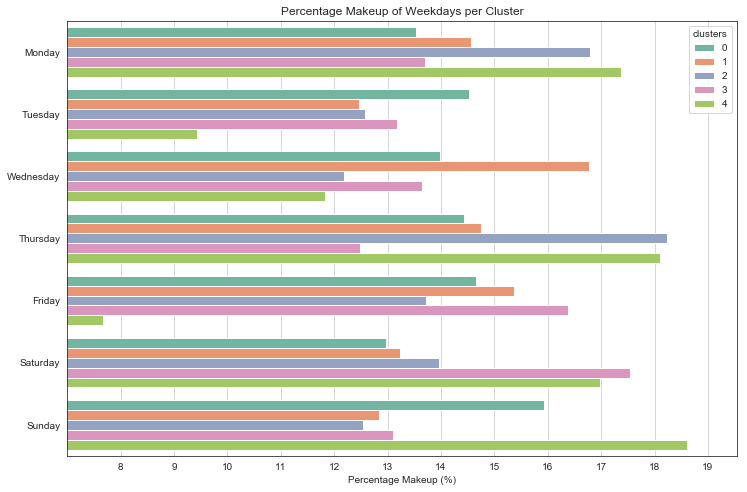

In [1367]:
weekday_piv = pd.pivot_table(df_with_clusters, values='event_unique_id', columns='clusters', index='occurrencedayofweek', aggfunc='count')
weekday_piv = weekday_piv.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday'])

for cluster in weekday_piv.columns:
    weekday_piv[cluster] = weekday_piv[cluster].apply(lambda x: (x / weekday_piv[cluster].values.sum()) * 100)

plt.figure(figsize=(12,8))
sns.barplot(x='count', y='occurrencedayofweek', hue='clusters', palette='Set2', 
            data=weekday_piv.stack().reset_index().rename(columns={0: 'count'}))
plt.title("Percentage Makeup of Weekdays per Cluster")
plt.ylabel(None)
plt.xlabel("Percentage Makeup (%)")
plt.xlim(7)
plt.grid(axis='x')
plt.xticks(range(8,20));